In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

raw_data_dir = os.path.join(data_dir, 'raw')
ids_mapping = os.path.join(raw_data_dir, 'IDS_mapping.csv')
diabetes_data = os.path.join(raw_data_dir, 'diabetic_data.csv')

mapping_data_dir = os.path.join(data_dir, 'Mapping')
os.makedirs(mapping_data_dir, exist_ok=True)

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

admission_type_mapping_data = os.path.join(mapping_data_dir, 'admission_type_mapping.csv')
discharge_disposition_data = os.path.join(mapping_data_dir, 'discharge_disposition_mapping.csv')
admission_source_mapping_data = os.path.join(mapping_data_dir, 'admission_source_mapping.csv')

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

In [3]:
df = pd.read_pickle(preprocessed_saved_filepath)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69987 non-null  int64   
 1   patient_nbr               69987 non-null  int64   
 2   race                      69987 non-null  category
 3   gender                    69987 non-null  object  
 4   age                       69987 non-null  object  
 5   admission_type_id         69987 non-null  category
 6   discharge_disposition_id  69987 non-null  category
 7   admission_source_id       69987 non-null  category
 8   time_in_hospital          69987 non-null  int64   
 9   medical_specialty         69987 non-null  category
 10  num_lab_procedures        69987 non-null  int64   
 11  num_procedures            69987 non-null  int64   
 12  num_medications           69987 non-null  int64   
 13  number_outpatient         69987 non-null  int64   

In [5]:
print(df.dtypes)

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                        object
age                           object
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum                  int64
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
glimepiride                    int64
glipizide                      int64
glyburide                      int64
p

In [6]:
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,max_glu_serum_measured,A1Cresult_measured,repaglinide_measured,glimepiride_measured,rosiglitazone_measured,pioglitazone_measured,glyburide_measured,glipizide_measured,metformin_measured,insulin_measured
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Unknown,...,No,No,No,No,No,No,No,No,No,Yes
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,...,No,No,No,No,No,No,No,Yes,No,No
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Unknown,...,No,No,No,No,No,No,No,No,No,Yes
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Unknown,...,No,No,No,No,No,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,Unknown,...,No,Yes,No,No,No,No,Yes,No,No,Yes
101755,443842022,188574944,Other,Female,[40-50),1,1,7,14,Unknown,...,No,Yes,No,No,No,No,No,Yes,No,Yes
101756,443842070,140199494,Other,Female,[60-70),1,1,7,2,Unknown,...,No,No,No,No,No,No,No,No,No,Yes
101758,443842340,120975314,Caucasian,Female,[80-90),1,1,7,5,Unknown,...,No,No,No,No,No,No,No,No,No,Yes


In [7]:
for col in df.columns:
    if 'gender' in col:
        df[col] = df[col].astype('category')

In [8]:
df["readmitted"] = df["readmitted"].map({"YES": 1, "NO": 0})

In [9]:
df.drop(columns=["encounter_id", "patient_nbr", "age", "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "glimepiride", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69987 non-null  category
 1   gender                    69987 non-null  category
 2   admission_type_id         69987 non-null  category
 3   discharge_disposition_id  69987 non-null  category
 4   admission_source_id       69987 non-null  category
 5   time_in_hospital          69987 non-null  int64   
 6   medical_specialty         69987 non-null  category
 7   num_lab_procedures        69987 non-null  int64   
 8   num_procedures            69987 non-null  int64   
 9   num_medications           69987 non-null  int64   
 10  number_outpatient         69987 non-null  int64   
 11  number_emergency          69987 non-null  int64   
 12  number_inpatient          69987 non-null  int64   
 13  diag_1                    69987 non-null  category

In [11]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
categorical_cols = X.select_dtypes(include=["category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

numerical_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Step 3: Build the Random Forest pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42, n_estimators=100)),
    ]
)

In [13]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_freque...
       'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'change', 'diabetesMed', 'age-binned',
       'max_glu_serum_measured', 'A1Cresult_measured', 'repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [14]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.63
Precision: 0.58
Recall: 0.33
F1 Score: 0.42


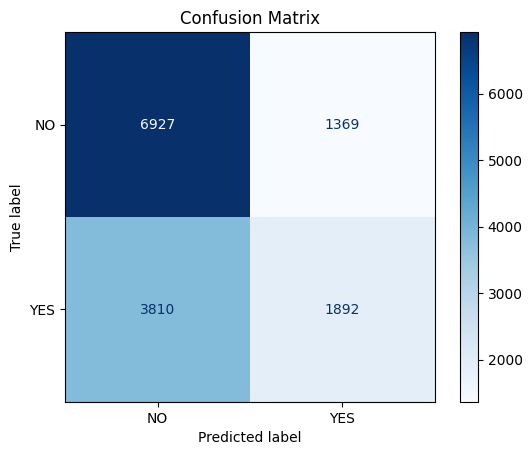

In [15]:
evaluate_model(model, X_test, y_test)

Hyper-parameter tuning with GridSearchCV

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy: 0.64
Precision: 0.60
Recall: 0.32
F1 Score: 0.42


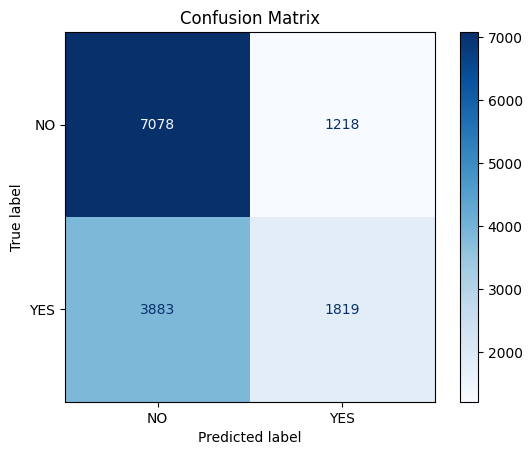

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

model_for_gridsearch= Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

grid_search = GridSearchCV(
    estimator=model_for_gridsearch,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

evaluate_model(grid_search.best_estimator_, X_test, y_test)